## Entrenamiento de Modelo

### Relevancia de la Estrategia de MLOps

La implementación de una estrategia de MLOps en el análisis del dataset de hongos cobra una importancia crucial, especialmente cuando abordamos la pregunta: *"¿podemos determinar si un hongo es comestible basándonos en sus características físicas?"*. Esta pregunta no solo plantea un desafío analítico y de modelado significativo, sino que también implica una profunda responsabilidad ética y de seguridad. En ámbitos donde la salud humana podría estar en juego, la precisión y fiabilidad de las predicciones de nuestro modelo no son meramente objetivos deseables, sino imperativos críticos.

En este contexto, una estrategia de MLOps es esencial, ya que permite la iteración continua y sistemática sobre el modelo, buscando optimizar su desempeño mientras se asegura la precisión y fiabilidad del sistema. La incorporación de MLOps facilita una mejora constante mediante la automatización, la integración y la entrega continuas, junto con el monitoreo y mantenimiento en producción, lo que es crucial para manejar la delicada naturaleza de la pregunta de investigación y garantizar la seguridad de las predicciones.

En consonancia con este enfoque iterativo y basado en la necesidad de equilibrar la precisión con la responsabilidad, elegimos comenzar nuestro proceso de modelado con un modelo base sencillo: la regresión logística. Esta elección se fundamenta en su interpretabilidad, simplicidad y eficacia probada como punto de partida en problemas de clasificación. A partir de este modelo base, podemos evaluar su desempeño como línea de base y, apoyados por la infraestructura y prácticas que MLOps facilita, proceder a experimentar y mejorar iterativamente. Esto nos permite explorar modelos más complejos y ajustar parámetros con el objetivo final de optimizar la precisión y la seguridad de nuestras predicciones, garantizando así que nuestro sistema de predicción evolucione de manera responsable y efectiva para proteger la salud y el bienestar de las personas.

### Importación de Librerías

In [61]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from rich import print

%matplotlib inline

### Carga del Dataset

In [62]:
parent_directory = os.path.dirname(os.getcwd())
path_primary_data = os.path.join(parent_directory, "data", "secondary_data.csv")
df = pd.read_csv(path_primary_data, sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

### Validación de Datos

In [63]:
# Verificar si hay filas duplicadas
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 146

In [64]:
# Verificar si hay valores faltantes en cada columna
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:

class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64

In [65]:
def detect_outliers_iqr(dataframe):
    """
    Detecta outliers en todas las columnas numéricas de un DataFrame usando el método del rango intercuartílico (IQR).
    
    Parámetros:
    - dataframe: DataFrame de pandas que contiene las variables numéricas.
    
    Retorna:
    - Un DataFrame que contiene solo las filas que son consideradas outliers en alguna de las columnas numéricas.
    """
    outliers_df = pd.DataFrame(columns=dataframe.columns)
    
    # Selecciona solo las columnas numéricas; en caso de que se haya ingresado un DataFrame con columnas categóricas
    numeric_cols = dataframe.select_dtypes(include=['int64', 'float64'])
    
    for column in numeric_cols:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtra los outliers
        filter_outliers = (dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)
        outliers_in_column = dataframe[filter_outliers]
        
        # Agrega los outliers al DataFrame de outliers
        outliers_df = pd.concat([outliers_df, outliers_in_column], axis=0).drop_duplicates().reset_index(drop=True)
    
    return outliers_df


In [66]:
# %%capture --no-display
# Detectando outliers en el DataFrame de variables numéricas
outliers_df = detect_outliers_iqr(df)

C:\Users\ferna\AppData\Local\Temp\ipykernel_27760\2658367427.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outliers_df = pd.concat([outliers_df, outliers_in_column], axis=0).drop_duplicates().reset_index(drop=True)


### Limpieza de Datos

- Tratar los valores faltantes (imputación, eliminación de filas/columnas, etc.).
- Identificar y manejar valores atípicos (outliers).
- Manejar datos duplicados y/o inconsistentes.

#### Eliminación de outliers

In [67]:
# Eliminar filas con outliers del conjunto de datos original
df_no_outliers = df.drop(outliers_df.index)
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55729 entries, 5340 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 55729 non-null  object 
 1   cap-diameter          55729 non-null  float64
 2   cap-shape             55729 non-null  object 
 3   cap-surface           43419 non-null  object 
 4   cap-color             55729 non-null  object 
 5   does-bruise-or-bleed  55729 non-null  object 
 6   gill-attachment       47257 non-null  object 
 7   gill-spacing          33843 non-null  object 
 8   gill-color            55729 non-null  object 
 9   stem-height           55729 non-null  float64
 10  stem-width            55729 non-null  float64
 11  stem-root             8074 non-null   object 
 12  stem-surface          20474 non-null  object 
 13  stem-color            55729 non-null  object 
 14  veil-type             353 non-null    object 
 15  veil-color      

#### Eliminación de Variables No Deseadas

In [69]:
# Eliminar columnas de acuerdo con observaciones en el análisis exploratorio
features_to_drop = ['cap-shape', 'does-bruise-or-bleed', 'gill-spacing', 'gill-color', 'stem-height', 'stem-color', 'ring-type', 'habitat', 'season']
df_clean = df_no_outliers.drop(columns=features_to_drop)
df_clean.head(10)

,class,cap-diameter,cap-surface,cap-color,gill-attachment,stem-width,stem-root,stem-surface,veil-type,veil-color,has-ring,spore-print-color
5340,e,9.58,NaN,g,s,21.69,b,NaN,NaN,NaN,f,NaN
5341,e,8.19,NaN,n,s,20.02,b,NaN,NaN,NaN,f,NaN
5342,e,9.04,NaN,g,s,21.65,b,NaN,NaN,NaN,f,NaN
5343,e,9.49,NaN,n,s,19.68,b,NaN,NaN,NaN,f,NaN
5344,e,10.01,NaN,n,s,21.06,b,NaN,NaN,NaN,f,NaN
5345,e,7.63,NaN,n,s,20.53,b,NaN,NaN,NaN,f,NaN
5346,e,7.80,NaN,n,s,18.09,b,NaN,NaN,NaN,f,NaN
5347,e,9.11,NaN,g,s,18.91,b,NaN,NaN,NaN,f,NaN
5348,e,6.72,NaN,n,s,19.54,b,NaN,NaN,NaN,f,NaN
5349,e,9.69,NaN,n,s,21.30,b,NaN,NaN,NaN,f,NaN


### División de Datos

#### Conjunto de Entrenamiento y Prueba

In [70]:
# División de datos en variables independientes (X) y dependientes (y)
X = df_clean.drop('class', axis=1)  # Características o variables independientes
y = df_clean['class']  # Variable objetivo o dependiente

# División en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Imprimir información sobre la división de datos
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento:
(44583, 11)

Tamaño del conjunto de prueba:
(11146, 11)

#### Conjunto de Entrenamiento: Variables Numéricas y Categóricas

In [71]:
# Identificar características numéricas y categóricas en el conjunto de entrenamiento
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

### Transformación de Datos

In [72]:
# Definir transformadores para variables numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputación utilizando la mediana, debido a la distribución sesgada de los datos
    ('standard_scaler', StandardScaler()),  # Estandarización
    ('min_max_scaler', MinMaxScaler())  # Normalización
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputación utilizando la moda
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Codificación utilizando OneHotEncoder, solo tenemos variables categóricas nominales
])

In [73]:
# Crear el preprocesador con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])


In [74]:
# Crear el pipeline con el preprocesador y el modelo de regresión logística
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

### Entrenamiento del Modelo

In [75]:
# Entrenar el modelo base de regresión logística utilizando el conjunto de entrenamiento transformado
baseline_model = baseline_pipeline.fit(X_train, y_train)

In [76]:
baseline_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('min_max_scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['cap-diameter', 'stem-width'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['cap-surface', 'cap-color', 'gill-attachment', 'stem-root',
       'stem-surface', 'veil-type', 'veil-color', 'has-ring',
       'spore-print-color'],
      dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=1000))])

### Evaluación del Modelo (Baseline)

In [77]:
# Realizar predicciones utilizando el conjunto de prueba transformado
y_pred = baseline_model.predict(X_test)
print(y_pred)

['p' 'e' 'e' ... 'e' 'p' 'p']

In [78]:
# Evaluar el rendimiento del modelo base en el conjunto de prueba
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='p')
recall = recall_score(y_test, y_pred, pos_label='p')
f1 = f1_score(y_test, y_pred, pos_label='p')
auc_roc = roc_auc_score(y_test, baseline_model.predict_proba(X_test)[:, 1])
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Imprimir los resultados
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC-ROC:", auc_roc)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.7769603445182128

Precision: 0.8034515819750719

Recall: 0.8001273074474857

F1-score: 0.8017859990432148

AUC-ROC: 0.8647388154961075

Confusion Matrix:
 [[3632 1230]
 [1256 5028]]

Classification Report:
               precision    recall  f1-score   support

           e       0.74      0.75      0.75      4862
           p       0.80      0.80      0.80      6284

    accuracy                           0.78     11146
   macro avg       0.77      0.77      0.77     11146
weighted avg       0.78      0.78      0.78     11146

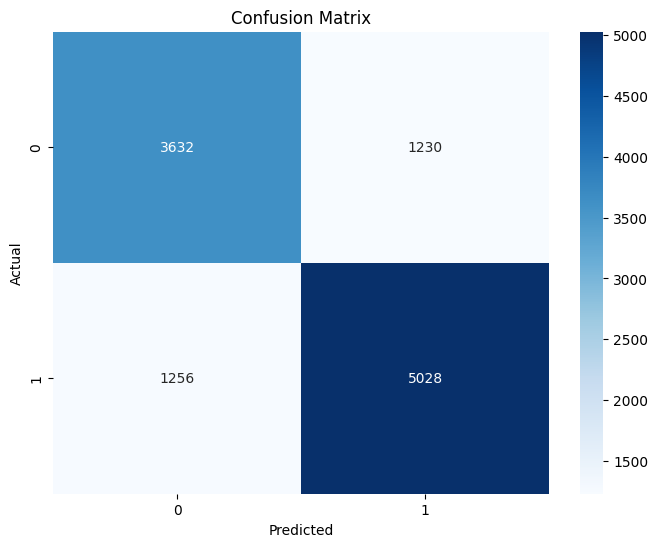

In [79]:
# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_baseline.png')  # Save the confusion matrix plot
plt.show()

In [80]:
raise Exception('Stopping execution')

Exception: Stopping execution

### Set Up MLflow

In [ ]:
"""
def setup_mlflow_tracking(mlruns_path, experiment_name, tags=None):
    """
    Sets up MLflow tracking with a local file storage backend.
    Creates an experiment if it doesn't exist.

    Args:
        mlruns_path (str): The path to the mlruns directory.
        experiment_name (str): The name of the experiment.

    Returns:
        mlflow.entities.Experiment: The active MLflow experiment.
    """

    tracking_uri = "file:///" + os.path.abspath(mlruns_path)
    os.environ["MLFLOW_TRACKING_URI"] = tracking_uri
    mlflow.set_tracking_uri(tracking_uri)

    print(f"MLflow Tracking URI: {tracking_uri}")

    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment:
        print(f"Existing experiment found: {experiment.name}")
    else:
        experiment = mlflow.create_experiment(
            experiment_name, artifact_location=mlruns_path, tags=tags
        )
        print(f"New experiment created: {experiment.experiment_id}")

    mlflow.set_experiment(experiment.experiment_id)  
    return experiment


mlruns_path = 'c:/Users/ferna/.vscode/GitHub/a01110946/MushroomDataset/mlruns'
experiment_name = "mushroom_classification"
tags = {"data": "mushrooms"}

experiment = setup_mlflow_tracking(mlruns_path, experiment_name)


# Confirm data at the end
print(f"Artifact URI: {mlflow.get_artifact_uri()}")
print(f"Experiment Name: {experiment.name}")
print(f"Experiment ID: {experiment.experiment_id}")
print(f"Experiment Location: {experiment.artifact_location}")


run = mlflow.active_run()
if run:  # Check if a run is still active
    print(f"run_id: {run.info.run_id}")
    mlflow.end_run()
else:
    print("No active run found")


# Registrar las métricas y artefactos en MLflow
with mlflow.start_run(run_name="Baseline Model Evaluation"):
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("auc_roc", auc_roc)
    mlflow.log_artifact("confusion_matrix_baseline.png")
    mlflow.log_text(class_report, "classification_report_baseline.txt")
"""